In [1]:
import tensorflow as tf
from tensorflow.keras.models import load_model, Model, Sequential
from tensorflow.keras.layers import Dense, InputLayer, LeakyReLU, Input, BatchNormalization, Dropout
from tensorflow.math import l2_normalize
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, log_loss
from sklearn.preprocessing import MinMaxScaler
import imageio.v3 as iio
import time
import os
import seaborn as sns

# Suppress the DecompressionBombWarning
import warnings
from PIL import Image
warnings.simplefilter('ignore', Image.DecompressionBombWarning)

In [2]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from keras.models import load_model

## CNN Input PreProcessing

In [3]:
# read labels files
train_labels_df = pd.read_csv("train_labels.csv")
test_labels_df = pd.read_csv("test_labels.csv")

In [3]:
def read_data(folder_name, labels_df):
    data = []
    labels = []
    i = 0
    files = os.listdir(folder_name)
    print(files[0:5])
    for filename in files:
        i += 1
        data.append(iio.imread(os.path.join(folder_name, filename)).flatten())
        labels.append(labels_df.loc[labels_df["Id"] == os.path.splitext(filename)[0], "Class"].iloc[0])
        print(f"|{'='*int(i*50/len(files)) + '-'*(50-int(i*50/len(files)))}| {i*100//len(files)}%", end="\r")
    print()
    return data, labels

In [17]:
# read images file

start = time.time()

# read asm train images
print("Reading asm train files...")
asm_data_train, asm_labels_train = read_data("train_asm_image", train_labels_df)

# read asm test images
print("Reading bytes train files...")
asm_data_test, asm_labels_test = read_data("test_asm_image", test_labels_df)

# read bytes train images
print("Reading asm test files...")
bytes_data_train, bytes_labels_train = read_data("train_byte_image", train_labels_df)

# read bytes test images
print("Reading bytes test files...")
bytes_data_test, bytes_labels_test = read_data("test_byte_image", test_labels_df)

print("\nCompleted!")
end = time.time()

print("\nTime taken: {}m {}s".format(int((end-start)//60), int((end-start)%60)))

Reading asm train files...
['065EZhxgbLRSHsB87uIF.png', '08BX5Slp2I1FraZWbc6j.png', '0aVNj3qFgEZI6Akf4Kuv.png', '0DbLeKSoxu47wjqVHsi9.png', '0EL7OGZKozbiNCVP61gk.png']
|==================================================| 100%
Reading bytes train files...
['04hSzLv5s2TDYPlcgpHB.png', '05aiMRw13bYWqZ8OHvjl.png', '0gcZkSFr7VnEmLPbTxUe.png', '0gxJ1YmwFUvnOzoM8N53.png', '0ItXlAUOhK8ZYdDf7HW4.png']
|==================================================| 100%
Reading asm test files...
['065EZhxgbLRSHsB87uIF.png', '08BX5Slp2I1FraZWbc6j.png', '0aVNj3qFgEZI6Akf4Kuv.png', '0DbLeKSoxu47wjqVHsi9.png', '0EL7OGZKozbiNCVP61gk.png']
|==================================================| 100%
Reading bytes test files...
['04hSzLv5s2TDYPlcgpHB.png', '05aiMRw13bYWqZ8OHvjl.png', '0gcZkSFr7VnEmLPbTxUe.png', '0gxJ1YmwFUvnOzoM8N53.png', '0ItXlAUOhK8ZYdDf7HW4.png']
|==================================================| 100%

Completed!

Time taken: 2m 0s


In [18]:
def save_list(data_list, file_name):
    with open(file_name, 'w') as file:
        for item in data_list:
            line = ' '.join(map(str, item))  # Convert each integer to string and join with spaces
            file.write(f"[{line}]\n")  # Format to look like the original file

def load_list(file_name):
    with open(file_name, 'r') as file:
        data = []
        for line in file:
            # Remove any unnecessary characters and split by spaces
            line = line.strip().replace('[', '').replace(']', '')
            # Convert each number to an integer and add to the list
            if line:
                data.append([int(num) for num in line.split()])
    return data


In [22]:
# pre process images to a standard size (asm)
image_size = (64, 64)

def standardise_size(arr, size):
    if arr.size < size[0]*size[1]:
        return np.pad(arr, (0, size[0]*size[1]-arr.size), mode='constant', constant_values=0).reshape(size[0], size[1])
    else:
        return arr[:(size[0]*size[1])].reshape(size[0], size[1])

asm_data_train_standardised = np.array([standardise_size(arr, image_size) for arr in asm_data_train])
asm_data_test_standardised = np.array([standardise_size(arr, image_size) for arr in asm_data_test])

# pre process images to a standard size (bytes)
image_size_bytes = (512, 512)

bytes_data_train_standardised = np.array([standardise_size(arr, image_size_bytes) for arr in bytes_data_train])
bytes_data_test_standardised = np.array([standardise_size(arr, image_size_bytes) for arr in bytes_data_test])

In [4]:
# pre process labels into one hot encodings
def one_hot_encode(labels):
    labels = np.array(labels)
    labels[labels < 5] = labels[labels < 5] - 1
    labels[labels > 5] = labels[labels > 5] - 2
    encoded_labels = np.identity(8)[labels]
    return encoded_labels

In [23]:
# pre process labels into one hot encodings
def one_hot_encode(labels):
    labels = np.array(labels)
    labels[labels < 5] = labels[labels < 5] - 1
    labels[labels > 5] = labels[labels > 5] - 2
    encoded_labels = np.identity(8)[labels]
    return encoded_labels

asm_labels_train_encoded = one_hot_encode(asm_labels_train)
asm_labels_test_encoded = one_hot_encode(asm_labels_test)
bytes_labels_train_encoded = one_hot_encode(bytes_labels_train)
bytes_labels_test_encoded = one_hot_encode(bytes_labels_test)

In [ ]:
np.save("asm_data_train_standardised.npy", asm_data_train_standardised)
np.save("asm_labels_train_encoded.npy", asm_labels_train_encoded)
np.save("asm_data_test_standardised.npy", asm_data_test_standardised)
np.save("asm_labels_test_encoded.npy", asm_labels_test_encoded)

np.save("bytes_data_train_standardised.npy",bytes_data_train_standardised)
np.save("bytes_labels_train_encoded.npy", bytes_labels_train_encoded)
np.save("bytes_data_test_standardised.npy", bytes_data_test_standardised )
np.save("bytes_labels_test_encoded.npy", bytes_labels_test_encoded)

In [5]:
asm_data_train_standardised = np.load("asm_data_train_standardised.npy")
asm_labels_train_encoded = np.load("asm_labels_train_encoded.npy")
asm_data_test_standardised = np.load("asm_data_test_standardised.npy")
asm_labels_test_encoded = np.load("asm_labels_test_encoded.npy")

bytes_data_train_standardised = np.load("bytes_data_train_standardised.npy")
bytes_labels_train_encoded = np.load("bytes_labels_train_encoded.npy")
bytes_data_test_standardised = np.load("bytes_data_test_standardised.npy")
bytes_labels_test_encoded = np.load("bytes_labels_test_encoded.npy")

## MLP Input PreProcessing

In [6]:
asm_1_gram = pd.read_csv('asm_features_1_gram_dropped.csv')
asm_2_gram = pd.read_csv('asm_features_2_grams_dropped.csv')
asm_prefix_counts = pd.read_csv('asm_prefix_counts.csv')
bytes_1_gram = pd.read_csv('bytes_features_1_grams.csv')
bytes_2_gram = pd.read_csv('top_170_imp_byte_bigram_df.csv')
file_sizes = pd.read_csv('file_sizes.csv')
dll = pd.read_csv('dll_occurences.csv')
punctuation = pd.read_csv('punctuation_occurences.csv')

train_labels = pd.read_csv('train_labels.csv')
test_labels = pd.read_csv('test_labels.csv')
train_labels = train_labels.drop('Unnamed: 0', axis=1)
test_labels = test_labels.drop('Unnamed: 0', axis=1)
train_labels = train_labels.rename(columns={'Id':'ID'})
test_labels = test_labels.rename(columns={'Id':'ID'})

In [7]:
def recursive_join(files):
  df = files[0]
  for i in range(1, len(files)):
    # print(i)
    df = df.merge(files[i], on= 'ID', how= 'inner')
    # print(df.head())
  return df

asm_prefix_counts = asm_prefix_counts.rename(columns={'File ID':'ID'})
file_sizes = file_sizes.rename(columns={'File ID':'ID'})

all_files = [asm_1_gram, asm_2_gram, asm_prefix_counts, bytes_1_gram, bytes_2_gram, file_sizes, dll, punctuation]
asm_files = [asm_1_gram, asm_2_gram, asm_prefix_counts, file_sizes[['ID', 'ASM File Size']], dll, punctuation]
bytes_files = [bytes_1_gram, bytes_2_gram, file_sizes[['ID', 'Bytes File Size']]]


In [8]:
all_data = recursive_join(all_files)
asm_data = recursive_join(asm_files)
bytes_data = recursive_join(bytes_files)

# Select columns with string (object) data type
string_columns_all = all_data.select_dtypes(include='object').columns.tolist()
string_columns_asm = asm_data.select_dtypes(include='object').columns.tolist()
string_columns_bytes = bytes_data.select_dtypes(include='object').columns.tolist()

id_col_all = all_data['ID']
all_data = all_data.drop(string_columns_all, axis=1)

id_col_asm = asm_data['ID']
asm_data = asm_data.drop(string_columns_asm, axis=1)

id_col_bytes = bytes_data['ID']
bytes_data = bytes_data.drop(string_columns_bytes, axis=1)

data_normalized_all = pd.DataFrame(tf.math.l2_normalize(all_data, axis=0), columns = all_data.columns)
data_normalized_asm = pd.DataFrame(tf.math.l2_normalize(asm_data.astype('float64'), axis=0), columns = asm_data.columns)
data_normalized_bytes = pd.DataFrame(tf.math.l2_normalize(bytes_data, axis=0), columns = bytes_data.columns)

# Add ID column back
data_normalized_all = pd.concat([id_col_all, data_normalized_all], axis=1)
data_normalized_asm = pd.concat([id_col_asm, data_normalized_asm], axis=1)
data_normalized_bytes = pd.concat([id_col_bytes, data_normalized_bytes], axis=1)

In [9]:
train_data_all = pd.merge(train_labels, data_normalized_all, on='ID', how='inner').sort_values(by='ID', key=lambda x: x.str.lower())
test_data_all = pd.merge(test_labels, data_normalized_all, on='ID', how='inner').sort_values(by='ID', key=lambda x: x.str.lower())
train_data_asm = pd.merge(train_labels, data_normalized_asm, on='ID', how='inner').sort_values(by='ID', key=lambda x: x.str.lower())
test_data_asm = pd.merge(test_labels, data_normalized_asm, on='ID', how='inner').sort_values(by='ID', key=lambda x: x.str.lower())
train_data_bytes = pd.merge(train_labels, data_normalized_bytes, on='ID', how='inner').sort_values(by='ID', key=lambda x: x.str.lower())
test_data_bytes = pd.merge(test_labels, data_normalized_bytes, on='ID', how='inner').sort_values(by='ID', key=lambda x: x.str.lower())

In [10]:
y_train_all = train_data_all['Class']
y_test_all = test_data_all['Class']
y_train_asm = train_data_asm['Class']
y_test_asm = test_data_asm['Class']
y_train_bytes = train_data_bytes['Class']
y_test_bytes = test_data_bytes['Class']


In [11]:
X_train_all = train_data_all.drop(['ID', 'Class'], axis=1).fillna(0)
X_test_all = test_data_all.drop(['ID', 'Class'], axis=1).fillna(0)
X_train_asm = train_data_asm.drop(['ID', 'Class'], axis=1).fillna(0)
X_test_asm = test_data_asm.drop(['ID', 'Class'], axis=1).fillna(0)
X_train_bytes = train_data_bytes.drop(['ID', 'Class'], axis=1).fillna(0)
X_test_bytes = test_data_bytes.drop(['ID', 'Class'], axis=1).fillna(0)

In [12]:
y_train_one_hot_all = one_hot_encode(y_train_all)
y_test_one_hot_all = one_hot_encode(y_test_all)
y_train_one_hot_asm = one_hot_encode(y_train_asm)
y_test_one_hot_asm = one_hot_encode(y_test_asm)
y_train_one_hot_bytes = one_hot_encode(y_train_bytes)
y_test_one_hot_bytes = one_hot_encode(y_test_bytes)

## RNN Input PreProcessing

In [13]:
asm_embeddings_train_df = pd.read_csv('asm_embeddings_train.csv')
asm_embeddings_test_df = pd.read_csv('asm_embeddings_test.csv')
bytes_embeddings_train_df = pd.read_csv('bytes_embeddings_train.csv')
bytes_embeddings_test_df = pd.read_csv('bytes_embeddings_test.csv')

In [14]:
half_sorted_train = pd.read_csv('train_labels.csv').sort_values(by='Id').reset_index(drop=True)
half_sorted_test = pd.read_csv('test_labels.csv').sort_values(by='Id').reset_index(drop=True)

In [15]:
asm_embeddings_train_df = pd.concat([asm_embeddings_train_df, half_sorted_train], axis=1).sort_values(by='Id', key=lambda x: x.str.lower())
asm_embeddings_test_df = pd.concat([asm_embeddings_test_df, half_sorted_test], axis=1).sort_values(by='Id', key=lambda x: x.str.lower())
bytes_embeddings_train_df = pd.concat([bytes_embeddings_train_df, half_sorted_train], axis=1).sort_values(by='Id', key=lambda x: x.str.lower())
bytes_embeddings_test_df = pd.concat([bytes_embeddings_test_df, half_sorted_test], axis=1).sort_values(by='Id', key=lambda x: x.str.lower())

In [28]:
asm_embeddings_train_df

,0,1,2,3,4,5,6,7,8,9,...,378,379,380,381,382,383,Label,Unnamed: 0,Id,Class
0,-0.095638,-0.090185,-0.011705,-0.018422,-0.138640,-0.000270,-0.074942,0.022901,0.028018,-0.005940,...,0.035637,0.063963,-0.003646,0.020770,-0.001463,-0.054817,1,1549,065EZhxgbLRSHsB87uIF,2
1,-0.070774,-0.099513,0.007644,-0.006091,-0.157708,-0.005634,-0.112545,0.042093,-0.003051,-0.015341,...,0.022800,0.059206,-0.031807,0.005620,0.029947,0.020711,4,7482,08BX5Slp2I1FraZWbc6j,6
20,-0.081087,-0.053607,-0.017023,-0.017717,-0.109684,0.000592,-0.052970,-0.026387,0.008233,0.029012,...,0.002512,0.060775,-0.009601,0.031094,0.013634,-0.064462,6,8631,0aVNj3qFgEZI6Akf4Kuv,8
2,-0.094549,-0.075519,0.015049,-0.014498,-0.133273,0.002099,-0.059020,0.005294,0.030478,-0.021016,...,0.008247,0.057271,-0.018965,0.020968,0.001289,-0.049942,1,1558,0DbLeKSoxu47wjqVHsi9,2
3,-0.109050,-0.083991,-0.027502,-0.042172,-0.085965,-0.025590,-0.012998,0.041166,0.019789,-0.011760,...,0.080969,0.123963,-0.058736,0.020564,0.012907,-0.060989,4,7488,0EL7OGZKozbiNCVP61gk,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
830,-0.118838,0.048299,-0.002548,-0.011011,0.051951,0.010292,0.115433,0.000701,-0.085925,-0.070654,...,0.061454,0.035641,0.158746,0.126410,0.046549,-0.015717,3,7421,LH5pzdDSPOtgIaBC1jWo,4
1277,-0.083100,-0.082586,-0.030819,-0.072083,-0.068548,-0.045040,0.023270,0.073747,0.065065,-0.025373,...,0.027423,0.099486,-0.047896,-0.039729,0.014968,0.024376,3,7425,ljFT1KeZmEiHxhuRbrcd,4
1278,-0.098557,-0.132246,-0.037110,-0.020431,-0.133384,-0.013941,-0.084515,0.062563,0.036590,-0.013647,...,0.054185,0.086875,-0.030455,0.006371,0.003036,-0.021977,3,7426,ljuryB4bfagHqV5FM9Ae,4
1279,-0.095681,-0.115527,-0.040630,-0.016427,-0.155970,-0.000200,-0.065446,0.049303,0.038968,-0.008032,...,0.053524,0.089104,-0.040664,0.015885,0.034874,-0.012596,3,7431,loIP1tiwELF9YNZQjSUO,4


In [16]:
num_class = 8

# Prepare data for model training
bytes_embeddings_train = bytes_embeddings_train_df.iloc[:, :-4].to_numpy()
bytes_embeddings_train = bytes_embeddings_train.reshape(bytes_embeddings_train.shape[0], bytes_embeddings_train.shape[1], 1)
bytes_label_train = to_categorical(bytes_embeddings_train_df['Label'], num_classes=num_class)

bytes_embeddings_test = bytes_embeddings_test_df.iloc[:, :-4].to_numpy()
bytes_embeddings_test = bytes_embeddings_test.reshape(bytes_embeddings_test.shape[0], bytes_embeddings_test.shape[1], 1)
bytes_label_test = to_categorical(bytes_embeddings_test_df['Label'], num_classes=num_class)

asm_embeddings_train = asm_embeddings_train_df.iloc[:, :-4].to_numpy()
asm_embeddings_train = asm_embeddings_train.reshape(asm_embeddings_train.shape[0], asm_embeddings_train.shape[1], 1)
asm_label_train = to_categorical(asm_embeddings_train_df['Label'], num_classes=num_class)

asm_embeddings_test = asm_embeddings_test_df.iloc[:, :-4].to_numpy()
asm_embeddings_test = asm_embeddings_test.reshape(asm_embeddings_test.shape[0], asm_embeddings_test.shape[1], 1)
asm_label_test = to_categorical(asm_embeddings_test_df['Label'], num_classes=num_class)

In [17]:
# Concatenate training embeddings along the feature axis (axis=1)
combined_embeddings_train = tf.concat([bytes_embeddings_train, asm_embeddings_train], axis=1)
print("Combined train embeddings shape:", combined_embeddings_train.shape)

# Concatenate testing embeddings along the feature axis (axis=1)
combined_embeddings_test = tf.concat([bytes_embeddings_test, asm_embeddings_test], axis=1)
print("Combined test embeddings shape:", combined_embeddings_test.shape)

Combined train embeddings shape: (1280, 768, 1)
Combined test embeddings shape: (320, 768, 1)


## Function Preparation

### Model Loading

In [18]:
# Load all necessary models for each combined model segment
asm_CNN_model = load_model('asm_CNN_model.h5')
bytes_CNN_model = load_model('bytes_CNN_model.h5')

asm_MLP_model = load_model('mlp_asm.h5')
bytes_MLP_model = load_model('mlp_bytes.h5')
asm_bytes_MLP_model = load_model('mlp_all.h5')

asm_RNN_model = load_model('RNN_model_asm_78.keras')
bytes_RNN_model = load_model('RNN_model_bytes_69.keras')
asm_bytes_RNN_model = load_model('RNN_model_combined_80_new.keras')

### Defining Function

**Model Evaluation Function**

Param: model, train_embeddings, test_embeddings, train_labels, test_labels

Output: Accuracy, mlogloss, confusion matrix

In [19]:
def training_loss_plot(model_history, title) :
    # plot training & validation loss values
    plt.plot(model_history.history['loss'], label='Training Loss')
    plt.plot(model_history.history['val_loss'], label='Validation Loss')
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.ylim(0,1.6)
    plt.legend(loc='upper right')
    plt.show()

In [20]:
def evaluate_final_model(final_model, train_embeddings, test_embeddings, train_labels, test_labels):
    
    #print("Evaluating on Training Data:")
    train_predictions = final_model.predict(train_embeddings)
    train_accuracy = accuracy_score(train_labels.argmax(axis=1), train_predictions.argmax(axis=1))
    train_log_loss = log_loss(train_labels, train_predictions)
    
    # Evaluate on test data
    print("Evaluating on Test Data:")
    test_predictions = final_model.predict(test_embeddings)
    test_accuracy = accuracy_score(test_labels.argmax(axis=1), test_predictions.argmax(axis=1))
    test_log_loss = log_loss(test_labels, test_predictions)

    
    print(f"Training Accuracy: {train_accuracy:.4f}, Log Loss: {train_log_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}, Log Loss: {test_log_loss:.4f}")
    
    # Confusion matrix for test set
    test_conf_matrix = confusion_matrix(test_labels.argmax(axis=1), test_predictions.argmax(axis=1))
    disp = ConfusionMatrixDisplay(confusion_matrix=test_conf_matrix)
    disp.plot(cmap='Blues')
    plt.title("Confusion Matrix")
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.show()

**Normalizing Embedding Function**

param: list of embeddings

output: concatenated normalized embedding

In [21]:
# Function to remove the last softmax layer and get embedding model
def get_embedding_layer_output(model):
    # Create a new model that outputs the second-to-last layer’s output
    return tf.keras.Model(inputs=model.inputs, outputs=model.layers[-2].output)

# Fcuntion to normalize and concatenate embeddings
def create_embeddings(embeddings_list):
    normalized_embeddings = [l2_normalize(embedding, axis=1) for embedding in embeddings_list]
    return tf.concat(normalized_embeddings, axis=1)

**y train and y test**

This is shared train_labels and test_labels

In [22]:
train_labels = asm_labels_train_encoded
test_labels = asm_labels_test_encoded

In [23]:
X_train_all.shape

(1280, 618)

## asm Combined Model

This part is to create the concatenated normalized embeddings

In [24]:
# TRAIN DATA

# Extract embeddings
asm_CNN_embedding = get_embedding_layer_output(asm_CNN_model)(asm_data_train_standardised)
asm_MLP_embedding = get_embedding_layer_output(asm_MLP_model)(X_train_asm)
asm_RNN_embedding = get_embedding_layer_output(asm_RNN_model)(asm_embeddings_train) #DONT FORGET TO CHANGE

# Create concatenated normalized embedding
asm_train_embeddings = create_embeddings([asm_CNN_embedding, asm_MLP_embedding, asm_RNN_embedding])

C:\Users\Hera\anaconda3\envs\keras_env\lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['input_layer_1']. Received: the structure of inputs=*
  warnings.warn(
C:\Users\Hera\anaconda3\envs\keras_env\lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['input_layer_5']. Received: the structure of inputs=*
  warnings.warn(
C:\Users\Hera\anaconda3\envs\keras_env\lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['input_layer_9']. Received: the structure of inputs=*
  warnings.warn(


In [25]:
# TEST DATA

# Extract embeddings
asm_CNN_embedding_test = get_embedding_layer_output(asm_CNN_model)(asm_data_test_standardised)
asm_MLP_embedding_test = get_embedding_layer_output(asm_MLP_model)(X_test_asm)
asm_RNN_embedding_test = get_embedding_layer_output(asm_RNN_model)(asm_embeddings_test) #DONT FORGET TO CHANGE

# Create concatenated normalized embedding
asm_test_embeddings = create_embeddings([asm_CNN_embedding_test, asm_MLP_embedding_test, asm_RNN_embedding_test])

This part is to create and fit model

In [27]:
# Build asm model
asm_model = Sequential([
    InputLayer(shape=asm_train_embeddings.shape[1:]),
    Dense(128, activation=LeakyReLU(alpha=0.01)),
    Dense(64, activation=LeakyReLU(alpha=0.01)),
    Dense(8, activation='softmax')  # Adjust based on number of classes
])

# Compile the model
asm_model.compile(optimizer= Adam(learning_rate=0.001, clipnorm = 1.0), loss='categorical_crossentropy', metrics=['accuracy'])

C:\Users\Hera\anaconda3\envs\keras_env\lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.5568 - loss: 1.7490 - val_accuracy: 0.9961 - val_loss: 0.6805
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9960 - loss: 0.4021 - val_accuracy: 1.0000 - val_loss: 0.0610
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9940 - loss: 0.0531 - val_accuracy: 1.0000 - val_loss: 0.0215
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0195 - val_accuracy: 1.0000 - val_loss: 0.0140
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0130 - val_accuracy: 1.0000 - val_loss: 0.0095
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0080 - val_accuracy: 1.0000 - val_loss: 0.0069
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0051 - val_accuracy: 1.0000 - val_loss: 0.0054
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0040 - val_accuracy: 1.0000 - val_loss:

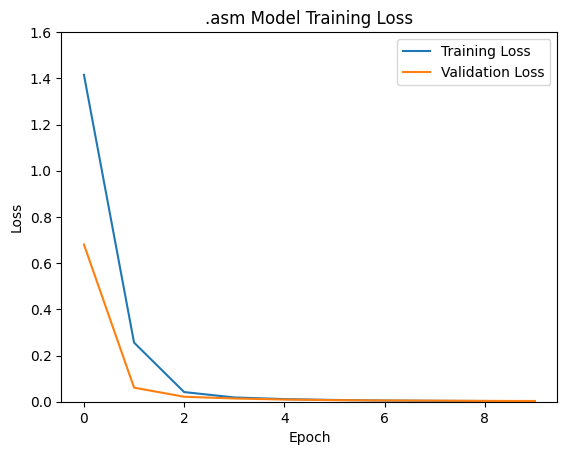

In [28]:
asm_history = asm_model.fit(asm_train_embeddings, train_labels, epochs=10, batch_size=32, validation_split=0.2)
training_loss_plot(asm_history, '.asm Model Training Loss')

This part is to evaluate the performance of the model

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Evaluating on Test Data:
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Training Accuracy: 1.0000, Log Loss: 0.0023
Test Accuracy: 0.9781, Log Loss: 0.0642


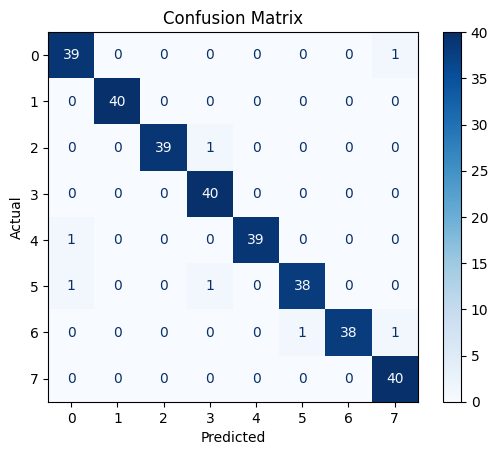

In [29]:
evaluate_final_model(asm_model, asm_train_embeddings, asm_test_embeddings, train_labels, test_labels)

## bytes Combined Model

This part is to create the concatenated normalized embeddings

In [31]:
# Placeholder for storing embeddings
bytes_CNN_embedding = []
batch_size = 64
num_batches = (len(bytes_data_train_standardised) + batch_size - 1) // batch_size

# Iterate over each batch
for i in range(num_batches):
    # Define batch start and end indices
    start = i * batch_size
    end = min((i + 1) * batch_size, len(bytes_data_train_standardised))
    
    # Extract the batch
    batch_data = bytes_data_train_standardised[start:end]
    print("Batch data shape:", batch_data.shape)
    
    # Process the batch through the embedding layer
    batch_embedding = get_embedding_layer_output(bytes_CNN_model)(batch_data)
    
    # Append batch results to embeddings list
    bytes_CNN_embedding.append(batch_embedding)

bytes_CNN_embedding = np.concatenate(bytes_CNN_embedding, axis=0)

Batch data shape: (64, 512, 512)


C:\Users\Hera\anaconda3\envs\keras_env\lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['input_layer_2']. Received: the structure of inputs=*
  warnings.warn(


Batch data shape: (64, 512, 512)
Batch data shape: (64, 512, 512)
Batch data shape: (64, 512, 512)
Batch data shape: (64, 512, 512)
Batch data shape: (64, 512, 512)
Batch data shape: (64, 512, 512)
Batch data shape: (64, 512, 512)
Batch data shape: (64, 512, 512)
Batch data shape: (64, 512, 512)
Batch data shape: (64, 512, 512)
Batch data shape: (64, 512, 512)
Batch data shape: (64, 512, 512)
Batch data shape: (64, 512, 512)
Batch data shape: (64, 512, 512)
Batch data shape: (64, 512, 512)
Batch data shape: (64, 512, 512)
Batch data shape: (64, 512, 512)
Batch data shape: (64, 512, 512)
Batch data shape: (64, 512, 512)


In [32]:
# TRAIN DATA

# Extract embeddings
#bytes_CNN_embedding = get_embedding_layer_output(bytes_CNN_model)(bytes_data_train_standardised)
bytes_MLP_embedding = get_embedding_layer_output(bytes_MLP_model)(X_train_bytes)
bytes_RNN_embedding = get_embedding_layer_output(bytes_RNN_model)(bytes_embeddings_train) #DONT FORGET TO CHANGE

# Create concatenated normalized embedding
bytes_train_embeddings = create_embeddings([bytes_CNN_embedding, bytes_MLP_embedding, bytes_RNN_embedding])

C:\Users\Hera\anaconda3\envs\keras_env\lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['input_layer_6']. Received: the structure of inputs=*
  warnings.warn(
C:\Users\Hera\anaconda3\envs\keras_env\lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['input_layer_7']. Received: the structure of inputs=*
  warnings.warn(


In [33]:
# Placeholder for storing embeddings
bytes_CNN_embedding_test = []
batch_size = 64
num_batches = (len(bytes_data_test_standardised) + batch_size - 1) // batch_size

# Iterate over each batch
for i in range(num_batches):
    # Define batch start and end indices
    start = i * batch_size
    end = min((i + 1) * batch_size, len(bytes_data_test_standardised))
    
    # Extract the batch
    batch_data = bytes_data_test_standardised[start:end]
    print("Batch data shape:", batch_data.shape)
    
    # Process the batch through the embedding layer
    batch_embedding = get_embedding_layer_output(bytes_CNN_model)(batch_data)
    
    # Append batch results to embeddings list
    bytes_CNN_embedding_test.append(batch_embedding)

bytes_CNN_embedding_test = np.concatenate(bytes_CNN_embedding_test, axis=0)

Batch data shape: (64, 512, 512)
Batch data shape: (64, 512, 512)
Batch data shape: (64, 512, 512)
Batch data shape: (64, 512, 512)
Batch data shape: (64, 512, 512)


In [34]:
# TEST DATA

# Extract embeddings
#bytes_CNN_embedding_test = get_embedding_layer_output(bytes_CNN_model)(bytes_data_test_standardised)
bytes_MLP_embedding_test = get_embedding_layer_output(bytes_MLP_model)(X_test_bytes)
bytes_RNN_embedding_test = get_embedding_layer_output(bytes_RNN_model)(bytes_embeddings_test) #DONT FORGET TO CHANGE

# Create concatenated normalized embedding
bytes_test_embeddings = create_embeddings([bytes_CNN_embedding_test, bytes_MLP_embedding_test, bytes_RNN_embedding_test])

This part is to create and fit model

In [35]:
# Build bytes model
bytes_model = Sequential([
    InputLayer(shape=bytes_train_embeddings.shape[1:]),
    Dense(128, activation=LeakyReLU(alpha=0.01)),
    Dense(64, activation=LeakyReLU(alpha=0.01)),
    Dense(8, activation='softmax')  # Adjust based on number of classes
])

bytes_model.compile(optimizer= Adam(learning_rate=0.001, clipnorm = 1.0), loss='categorical_crossentropy', metrics=['accuracy'])

C:\Users\Hera\anaconda3\envs\keras_env\lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.4737 - loss: 1.8259 - val_accuracy: 0.8789 - val_loss: 0.9347
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9358 - loss: 0.6539 - val_accuracy: 0.9883 - val_loss: 0.1848
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9668 - loss: 0.1778 - val_accuracy: 0.9961 - val_loss: 0.0802
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9881 - loss: 0.0844 - val_accuracy: 0.9961 - val_loss: 0.0533
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9882 - loss: 0.0460 - val_accuracy: 1.0000 - val_loss: 0.0345
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9968 - loss: 0.0308 - val_accuracy: 1.0000 - val_loss: 0.0259
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9946 - loss: 0.0221 - val_accuracy: 1.0000 - val_loss: 0.0207
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0169 - val_accuracy: 1.0000 - val_loss:

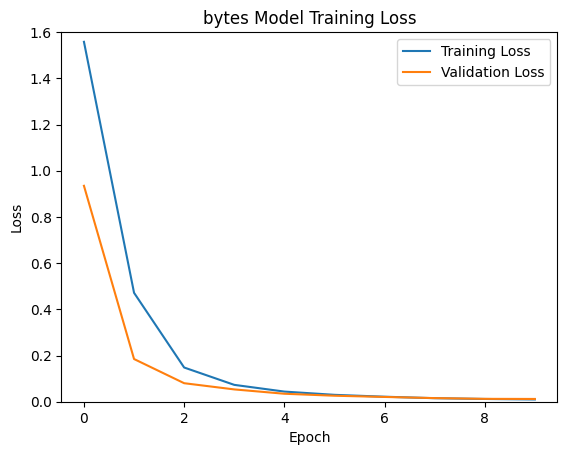

In [36]:
bytes_history = bytes_model.fit(bytes_train_embeddings, train_labels, epochs=10, batch_size=32, validation_split=0.2)
training_loss_plot(bytes_history, 'bytes Model Training Loss')

This part is to evaluate the performance of the model

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Evaluating on Test Data:
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Training Accuracy: 1.0000, Log Loss: 0.0088
Test Accuracy: 0.9219, Log Loss: 0.3216


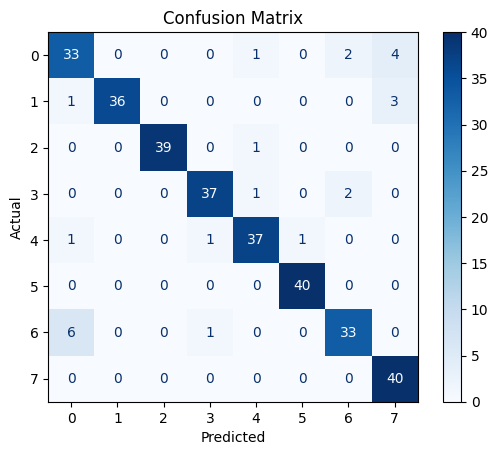

In [37]:
evaluate_final_model(bytes_model, bytes_train_embeddings, bytes_test_embeddings, train_labels, test_labels)

## all Combined Model

This part is to create the concatenated normalized embeddings

In [38]:
# TRAIN DATA

# Extract embeddings
asm_bytes_MLP_embedding = get_embedding_layer_output(asm_bytes_MLP_model)(X_train_all)
asm_bytes_RNN_embedding = get_embedding_layer_output(asm_bytes_RNN_model)(combined_embeddings_train) #DONT FORGET TO CHANGE

# Create concatenated normalized embedding
asm_bytes_train_embeddings = create_embeddings([asm_CNN_embedding, bytes_CNN_embedding, asm_bytes_MLP_embedding, asm_bytes_RNN_embedding])

C:\Users\Hera\anaconda3\envs\keras_env\lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['input_layer_4']. Received: the structure of inputs=*
  warnings.warn(
C:\Users\Hera\anaconda3\envs\keras_env\lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['input_layer_2']. Received: the structure of inputs=*
  warnings.warn(


In [39]:
# TEST DATA

# Extract embeddings

asm_bytes_MLP_embedding_test = get_embedding_layer_output(asm_bytes_MLP_model)(X_test_all)
asm_bytes_RNN_embedding_test = get_embedding_layer_output(asm_bytes_RNN_model)(combined_embeddings_test) #DONT FORGET TO CHANGE

# Create concatenated normalized embedding
asm_bytes_test_embeddings = create_embeddings([asm_CNN_embedding_test, bytes_CNN_embedding_test, asm_bytes_MLP_embedding_test, asm_bytes_RNN_embedding_test])

This part is to create and fit model

In [40]:
# Build bytes model
all_model = Sequential([
    InputLayer(shape=asm_bytes_train_embeddings.shape[1:]),
    Dense(128, activation=LeakyReLU(alpha=0.01)),
    Dense(64, activation=LeakyReLU(alpha=0.01)),
    Dense(8, activation='softmax')  # Adjust based on number of classes
])

all_model.compile(optimizer= Adam(learning_rate=0.001, clipnorm = 1.0), loss='categorical_crossentropy', metrics=['accuracy'])

C:\Users\Hera\anaconda3\envs\keras_env\lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6882 - loss: 1.6825 - val_accuracy: 0.9922 - val_loss: 0.4597
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9866 - loss: 0.2468 - val_accuracy: 1.0000 - val_loss: 0.0293
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9989 - loss: 0.0279 - val_accuracy: 1.0000 - val_loss: 0.0105
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0107 - val_accuracy: 1.0000 - val_loss: 0.0067
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0063 - val_accuracy: 1.0000 - val_loss: 0.0045
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0041 - val_accuracy: 1.0000 - val_loss: 0.0035
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0031 - val_accuracy: 1.0000 - val_loss: 0.0026
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0021 - val_accuracy: 1.0000 - val_loss:

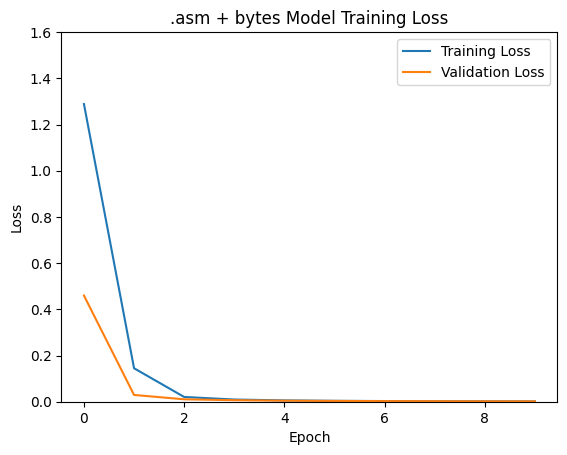

In [41]:
all_history = all_model.fit(asm_bytes_train_embeddings, train_labels, epochs=10, batch_size=32, validation_split=0.2)
training_loss_plot(all_history, '.asm + bytes Model Training Loss')

This part is to evaluate the performance of the model

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Evaluating on Test Data:
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Training Accuracy: 1.0000, Log Loss: 0.0013
Test Accuracy: 0.9906, Log Loss: 0.0288


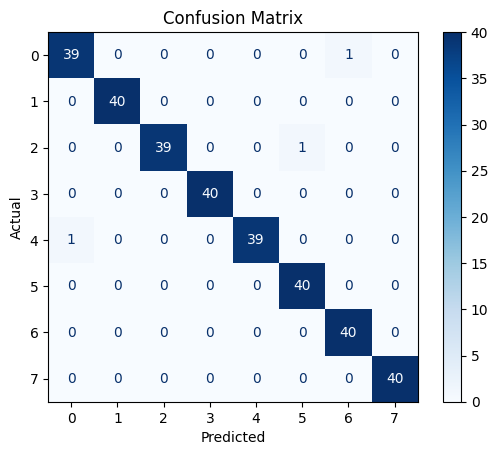

In [42]:
evaluate_final_model(all_model, asm_bytes_train_embeddings, asm_bytes_test_embeddings, train_labels, test_labels)

### Embedding Visualizations

In [43]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [44]:
# Convert embeddings to DataFrame and save to TSV
embeddings_df = pd.DataFrame(asm_bytes_test_embeddings)
embeddings_df.to_csv('embeddings.tsv', sep='\t', index=False, header=False)

# Convert labels to DataFrame and save to TSV
labels_df = pd.DataFrame(y_test_asm)
labels_df.to_csv('metadata.tsv', sep='\t', index=False, header=False)

In [45]:
def cluster(X, y, dim_reduction, dim, feature_type):
    if dim_reduction == 'PCA':
        reduction = PCA(n_components=dim)
    elif dim_reduction == 'TSNE':
        reduction = TSNE(n_components=dim, random_state=42)
        
    X_reduced = reduction.fit_transform(X)
    palette = sns.color_palette("colorblind", n_colors=8)
    
    if dim == 2:
        plt.figure(figsize=(10, 8))
        sns.scatterplot(x=X_reduced[:, 0], y=X_reduced[:, 1], hue=y, palette=palette, s=100, alpha=0.7)
    
        plt.title(f"{feature_type} Embedding Clusters", fontsize=16)
        plt.xlabel("Reduced Dimension 1", fontsize=12)
        plt.ylabel("Reduced Dimension 2", fontsize=12)
        plt.legend(title="Classes", loc="upper right")
        plt.show()
    elif dim == 3:
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')
        
        sc = ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=y_encoded, cmap=palette, s=100, alpha=0.7)

        ax.set_title(f"{feature_type} 3D Embedding Clusters", fontsize=16)
        ax.set_xlabel("Reduced Dimension 1", fontsize=12)
        ax.set_ylabel("Reduced Dimension 2", fontsize=12)
        ax.set_zlabel("Reduced Dimension 3", fontsize=12)

        legend1 = ax.legend(*sc.legend_elements(), title="Classes")
        ax.add_artist(legend1)

        plt.show()

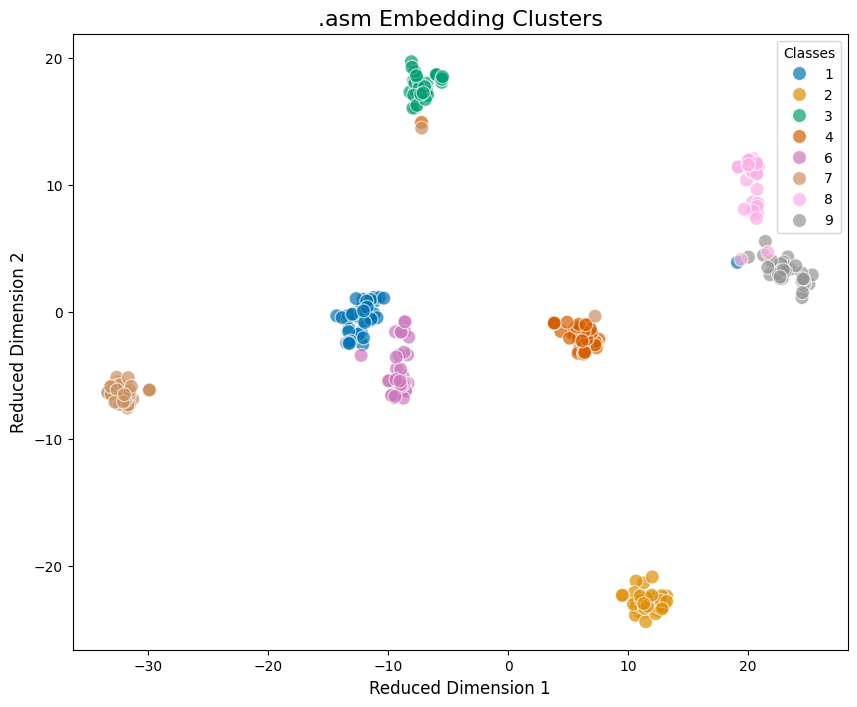

In [47]:
cluster(asm_test_embeddings, y_test_asm, 'TSNE', 2, '.asm')

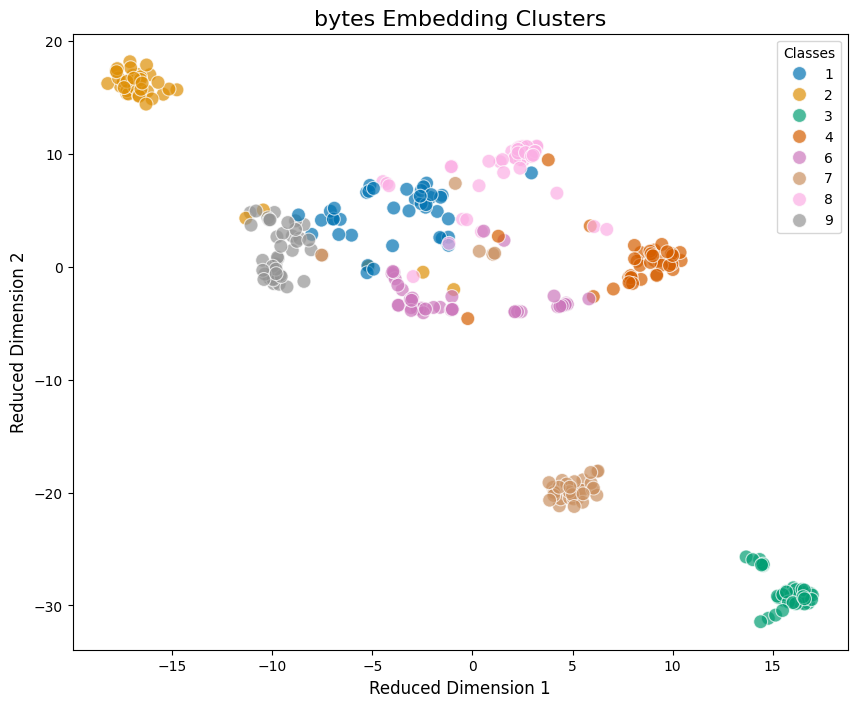

In [54]:
cluster(bytes_test_embeddings, y_test_asm, 'TSNE', 2, 'bytes')

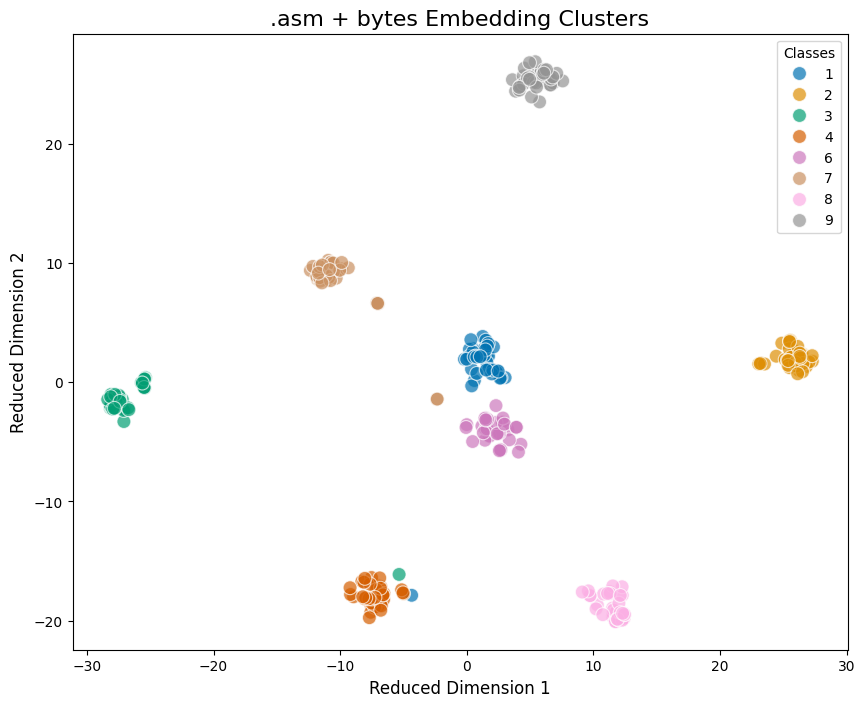

In [53]:
cluster(asm_bytes_test_embeddings, y_test_asm, 'TSNE', 2, '.asm + bytes')